# Environment settings

In [ ]:
!pip -q install -U "transformers>=4.46.0,<5.0.0" accelerate datasets evaluate jsonlines bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 53.9 MB/s eta 0:00:00


In [ ]:
import os, re, json, time, random, math
from decimal import Decimal, InvalidOperation
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
from decimal import Decimal, InvalidOperation
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import jsonlines
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)

# Stage 1: Black-box KD

## Set up hyperparameters

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# MODELS
TEACHER_NAME = "Qwen/Qwen2.5-7B-Instruct"
STUDENT_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

# PATHS
BASE_DIR = "./Distill_LLM"
os.makedirs(BASE_DIR, exist_ok=True)

# File COT
COT_JSONL_PATH = "./GSM8K_train_01.jsonl"

TRAIN_JSON       = os.path.join(BASE_DIR, "train.json")
TRAIN_LABELED    = os.path.join(BASE_DIR, "train_labeled.json")

# Stage-2 teacher topK logits (jsonl)
LOGITS_JSONL     = os.path.join(BASE_DIR, "teacher_topk_logits.jsonl")

# SEQ / DATA
DROP_WRONG = True
MAX_SEQ_LEN_STAGE1 = 1024
MAX_SEQ_LEN_STAGE2 = 1024

# STAGE 1 (SFT / black-box)
S1_EPOCHS = 3
S1_BSZ = 8
S1_GRAD_ACCUM = 4
S1_LR = 2e-5
S1_WARMUP_RATIO = 0.1
S1_WEIGHT_DECAY = 0.01

# PRECOMPUTE teacher top-K logits (Stage-2)
TOP_K = 10
TOP_M = 25
LOGITS_BATCH_SIZE = 32
PRECOMP_T = 2.0

# STAGE 2 (offline KD by idx, Top-K KL)
S2_EPOCHS = 3
S2_BSZ = 8
S2_GRAD_ACCUM = 4
S2_LR = 5e-6
S2_WARMUP_RATIO = 0.1
S2_WEIGHT_DECAY = 0.01

KD_RATIO = 0.35
KD_WARMUP_RATIO = 0.15
KD_WARMUP_STEPS = None
KD_TEMPERATURE = 2.0
KD_DIVERGENCE = "fkl"

MAX_TEST_SAMPLES = 100

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("COT exists:", os.path.exists(COT_JSONL_PATH))
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


COT exists: True
GPU: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


## Set up the evaluating method

In [ ]:
# Regex patterns
NUM_TOKEN_RE = re.compile(
    r"[-+−]?(?:\d+\s*/\s*\d+|(?:(?:\d{1,3}(?:[,\s\u00A0\u202F]\d{3})+)|(?:\d+))(?:\.\d+)?(?:[eE][+-]?\d+)?)"
)

HASH_MARK_RE = re.compile(r"####")

def _norm_unicode(s: str) -> str:
    """Normalize unicode minus & spaces"""
    return (
        s.replace("−", "-")
         .replace("\u00A0", " ")   # NBSP
         .replace("\u202F", " ")   # narrow NBSP
    )

def _remove_thousand_seps(s: str) -> str:
    """Remove commas and spaces (thousand separators). Keep decimal dot."""
    return s.replace(",", "").replace(" ", "")

def normalize_num(raw: str) -> Optional[str]:
    """
    Normalize a numeric string to canonical form.
    Handles: fractions, thousand separators, parentheses negatives, currency.
    Returns: string representation of the number in canonical form
    """
    if raw is None:
        return None

    s = _norm_unicode(str(raw)).strip()

    # Remove surrounding punctuation
    s = s.strip().strip(";:,.")

    # Parentheses negative: (123) or (1,234.55)
    neg_paren = False
    if s.startswith("(") and s.endswith(")"):
        neg_paren = True
        s = s[1:-1].strip()

    # Currency sign
    if s.startswith("$"):
        s = s[1:].strip()

    s = _norm_unicode(s)

    # Extract first numeric token
    m = NUM_TOKEN_RE.search(s)
    if m:
        s = m.group(0)

    s = _norm_unicode(s).strip()

    # Handle fractions a/b
    if "/" in s:
        parts = s.split("/")
        if len(parts) != 2:
            return None
        a, b = parts[0].strip(), parts[1].strip()
        try:
            a_d = Decimal(_remove_thousand_seps(_norm_unicode(a)))
            b_d = Decimal(_remove_thousand_seps(_norm_unicode(b)))
            if b_d == 0:
                return None
            d = a_d / b_d
        except (InvalidOperation, ValueError):
            return None
    else:
        try:
            cleaned = _remove_thousand_seps(s)
            d = Decimal(cleaned)
        except (InvalidOperation, ValueError):
            return None

    # Apply parentheses negative if needed
    if neg_paren and d > 0:
        d = -d

    # Canonical formatting: integers as int; decimals fixed-point
    try:
        if d == d.to_integral_value():
            return str(int(d))
        return format(d.normalize(), "f")
    except (InvalidOperation, ValueError):
        return None

def extract_final_from_text(text: str) -> Optional[str]:
    """
    Extract the final answer from text.
    Priority: First number after the FIRST #### marker.
    Fallback: Last number in the entire text.
    """
    if text is None:
        return None
    t = str(text)

    # 1) Find ALL #### positions
    hash_matches = list(HASH_MARK_RE.finditer(t))

    if hash_matches:
        # Take the FIRST #### position
        first_hash = hash_matches[0]
        after = t[first_hash.end():].lstrip()

        # Skip currency symbol if present
        if after.startswith("$"):
            after = after[1:].lstrip()

        # Find the first number after ####
        m = NUM_TOKEN_RE.search(after)
        if m:
            return normalize_num(m.group(0))

    # 2) Fallback: take the LAST numeric token in the whole text
    tokens = [mm.group(0) for mm in NUM_TOKEN_RE.finditer(t)]
    if not tokens:
        return None
    return normalize_num(tokens[-1])

def extract_gold(gold_text: str) -> Optional[str]:
    """Extract gold answer"""
    return extract_final_from_text(gold_text)

def _to_decimal(norm_str: Optional[str]) -> Optional[Decimal]:
    """Convert normalized numeric string to Decimal."""
    if norm_str is None:
        return None
    try:
        return Decimal(str(norm_str))
    except (InvalidOperation, ValueError):
        return None

def is_correct(pred_text: str, gold_text: str, eps: Optional[Decimal] = Decimal("0")) -> bool:
    p_str = extract_final_from_text(pred_text)
    g_str = extract_gold(gold_text)

    p = _to_decimal(p_str)
    g = _to_decimal(g_str)

    if (p is None) or (g is None):
        return False

    if eps is None:
        return p == g

    try:
        return abs(p - g) <= eps
    except Exception:
        return False


## Data processing for training

In [ ]:
# STEP 0: Build train.json + train_labeled.json from file COT
raw_rows, labeled_rows = [], []
dropped = 0
bad_examples = []

t0 = time.time()
if not os.path.exists(COT_JSONL_PATH):
    raise FileNotFoundError(f"Not found {COT_JSONL_PATH}")

with open(COT_JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)

        q = obj.get("question") or obj.get("instruction") or ""
        gold = obj.get("gold_answer") or obj.get("answer_gt") or obj.get("answer") or ""
        sols = obj.get("cot_solutions") or obj.get("solutions") or obj.get("outputs") or []

        if not q or not isinstance(sols, list) or len(sols) == 0:
            dropped += 1
            continue

        chosen = None
        for s in sols:
            if isinstance(s, str) and is_correct(s, gold):
                chosen = s
                break

        if chosen is None:
            if DROP_WRONG:
                dropped += 1
                if len(bad_examples) < 5:
                    bad_examples.append({"q": q, "gold": gold, "sol0": sols[0] if sols else ""})
                continue
            else:
                chosen = sols[0] if isinstance(sols[0], str) else str(sols[0])

        raw_rows.append({
            "instruction": q,
            "gold": gold,
            "solutions": sols,
        })
        labeled_rows.append({"instruction": q, "output": chosen.strip()})

with open(TRAIN_JSON, "w", encoding="utf-8") as f:
    json.dump(raw_rows, f, ensure_ascii=False, indent=2)
with open(TRAIN_LABELED, "w", encoding="utf-8") as f:
    json.dump(labeled_rows, f, ensure_ascii=False, indent=2)

print("Saved:", TRAIN_JSON)
print("Saved:", TRAIN_LABELED)
print("Kept:", len(labeled_rows), "Dropped:", dropped, "Time(s):", round(time.time()-t0, 2))
print("Bad examples:", bad_examples[:2])
print("Preview output:\n", labeled_rows[0]["output"] if labeled_rows else "")

Saved: ./Distill_LLM/train.json
Saved: ./Distill_LLM/train_labeled.json
Kept: 7343 Dropped: 0 Time(s): 0.37
Bad examples: []
Preview output:
 Step 1: Calculate 3 times the number of candy bars Max sold: 3 * 24 = 72
Step 2: Add 6 to the result from step 1: 72 + 6 = 78

#### 78


In [ ]:
SYSTEM_PROMPT = (
    "You are a precise math solver.\n"
    "Output ONLY the solution.\n"
    "Requirements:\n"
    "- Start with: Step 1:\n"
    "- Use short numbered steps with explicit arithmetic.\n"
    "- Do NOT repeat the question.\n"
    "- End with exactly: #### <number>\n"
    "- Do NOT include any other text.\n"
    "- Use plain text math (no LaTeX).\n"
)

FEW_SHOT_EXAMPLES = [
    {
        "question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
        "answer": "Step 1: Calculate clips sold in May = 48 / 2 = 24\nStep 2: Calculate total clips sold = 48 + 24 = 72\n\n#### 72"
    },
    {
        "question": "Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",
        "answer": "Step 1: Convert minutes to hours = 50 / 60 = 0.833 hours\nStep 2: Calculate earnings = 12 * 0.833 = 10\n\n#### 10"
    },
    {
        "question": "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
        "answer": "Step 1: Calculate half of wallet cost = 100 / 2 = 50\nStep 2: Calculate grandparents' gift = 15 * 2 = 30\nStep 3: Calculate total money Betty has = 50 + 15 + 30 = 95\nStep 4: Calculate money still needed = 100 - 95 = 5\n\n#### 5"
    },
    {
        "question": "Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?",
        "answer": "Step 1: Calculate pages read today = 12 * 2 = 24\nStep 2: Calculate total pages read so far = 12 + 24 = 36\nStep 3: Calculate remaining pages = 120 - 36 = 84\nStep 4: Calculate pages to read tomorrow = 84 / 2 = 42\n\n#### 42"
    }
]

def build_chat_prompt(tokenizer, question: str, add_generation_prompt: bool = True, use_few_shot: bool = False) -> str:
    """
    Build chat prompt with optional few-shot examples.

    Args:
        tokenizer: The tokenizer to use
        question: The question to answer
        add_generation_prompt: Whether to add generation prompt
        use_few_shot: Whether to include 4-shot examples (for evaluation only)
    """
    messages = [{"role": "system", "content": SYSTEM_PROMPT}]

    # Add few-shot examples if requested (for evaluation)
    if use_few_shot:
        for example in FEW_SHOT_EXAMPLES:
            messages.append({"role": "user", "content": example["question"] + "\n\nAnswer:\n"})
            messages.append({"role": "assistant", "content": example["answer"]})

    # Add the actual question
    messages.append({"role": "user", "content": question.strip() + "\n\nAnswer:\n"})

    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=add_generation_prompt)


# Dataset (mask prompt tokens)
class SFTDatasetMasked(Dataset):
    def __init__(self, rows: List[Dict[str, str]], tokenizer, max_length: int):
        self.rows = rows
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self): return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        # IMPORTANT: use_few_shot=False for training (default behavior)
        prompt = build_chat_prompt(self.tok, r["instruction"], add_generation_prompt=True, use_few_shot=False)
        full_text = prompt + "\n" + r["output"].strip()

        enc_full = self.tok(full_text, truncation=True, max_length=self.max_length, add_special_tokens=False)
        labels = enc_full["input_ids"].copy()

        enc_prompt = self.tok(prompt, add_special_tokens=False)
        prompt_len = len(enc_prompt["input_ids"])
        labels[:min(prompt_len, len(labels))] = [-100] * min(prompt_len, len(labels))

        enc_full["labels"] = labels
        return {k: torch.tensor(v, dtype=torch.long) for k, v in enc_full.items()}


class SFTDatasetMaskedWithIdx(Dataset):
    def __init__(self, rows: List[Dict[str, str]], tokenizer, max_length: int):
        self.rows = rows
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        # IMPORTANT: use_few_shot=False for training (default behavior)
        prompt = build_chat_prompt(self.tok, r["instruction"], add_generation_prompt=True, use_few_shot=False)
        full_text = prompt + "\n" + r["output"].strip()

        enc_full = self.tok(
            full_text,
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=False,
        )

        input_ids = enc_full["input_ids"]
        attn = enc_full["attention_mask"]

        # mask prompt tokens
        enc_prompt = self.tok(prompt, add_special_tokens=False)
        prompt_len = len(enc_prompt["input_ids"])

        labels = input_ids.copy()
        cut = min(prompt_len, len(labels))
        for j in range(cut):
            labels[j] = -100

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
            "__idx__": torch.tensor(idx, dtype=torch.long),
        }

In [ ]:
# Load tokenizers
teacher_tok = AutoTokenizer.from_pretrained(TEACHER_NAME, trust_remote_code=True)
student_tok = AutoTokenizer.from_pretrained(STUDENT_NAME, trust_remote_code=True)

# Prepare datasets / collators
rows_train = json.load(open(TRAIN_LABELED, "r", encoding="utf-8"))
train_s1 = SFTDatasetMasked(rows_train, student_tok, MAX_SEQ_LEN_STAGE1)
train_s2 = SFTDatasetMaskedWithIdx(rows_train, student_tok, MAX_SEQ_LEN_STAGE2)

base_collator = DataCollatorForSeq2Seq(
    tokenizer=student_tok,
    padding=True,
    label_pad_token_id=-100,
    return_tensors="pt",
)

def collator_keep_idx(features):
    if "__idx__" not in features[0]:
        missing = [i for i, f in enumerate(features) if "__idx__" not in f]
        raise KeyError(f"Missing __idx__ in features at positions: {missing[:10]}")
    idxs = torch.stack([f.pop("__idx__") for f in features]).long()
    batch = base_collator(features)
    batch["__idx__"] = idxs
    return batch

data_collator_s1 = base_collator
data_collator_s2 = collator_keep_idx


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## Stage 1 training

In [ ]:
# STAGE 1: Train student (black-box SFT)
student_s1 = AutoModelForCausalLM.from_pretrained(
    STUDENT_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)
student_s1.config.use_cache = False

S1_OUT = os.path.join(BASE_DIR, "student_stage1_blackbox")
args_s1 = TrainingArguments(
    output_dir=S1_OUT,
    per_device_train_batch_size=S1_BSZ,
    gradient_accumulation_steps=S1_GRAD_ACCUM,
    num_train_epochs=S1_EPOCHS,
    learning_rate=S1_LR,
    warmup_ratio=S1_WARMUP_RATIO,
    lr_scheduler_type="cosine",
    weight_decay=S1_WEIGHT_DECAY,
    logging_steps=20,
    save_steps=200,
    bf16=True,
    gradient_checkpointing=True,
    report_to=[],
)

trainer_s1 = Trainer(
    model=student_s1,
    args=args_s1,
    train_dataset=train_s1,
    data_collator=data_collator_s1,
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
print("Starting Stage 1 training...")
trainer_s1.train()
trainer_s1.save_model(S1_OUT)
student_tok.save_pretrained(S1_OUT)
print(f"Saved Stage 1 model: {S1_OUT}")

Starting Stage 1 training...


/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
20,0.416500
40,0.287700
60,0.248000
80,0.248600
100,0.240100
120,0.232600
140,0.221500
160,0.226100
180,0.212700
200,0.222700


Saved Stage 1 model: ./Distill_LLM/student_stage1_blackbox


In [ ]:
ds_test = load_dataset("gsm8k", "main", split="test")
if MAX_TEST_SAMPLES is not None and MAX_TEST_SAMPLES < len(ds_test):
    ds_test = ds_test.select(range(MAX_TEST_SAMPLES))

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

## Implement a function to generate answers and ratings.

In [ ]:
# Quick eval GSM8K (subset)
@torch.no_grad()
def generate_answer(model, tokenizer, question: str, max_new_tokens=256, use_few_shot=True):
    """
    Generate answer with optional few-shot prompting.
    Default use_few_shot=True for evaluation (matching paper).
    """
    prompt = build_chat_prompt(tokenizer, question, add_generation_prompt=True, use_few_shot=use_few_shot)
    inp = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)  # Increased max_length for few-shot
    out = model.generate(
        **inp,
        do_sample=False,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True,
    )
    gen_ids = out[0, inp["input_ids"].shape[1]:]
    return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()


def eval_gsm8k(model, tokenizer, ds_eval, use_few_shot=True):
    """
    Evaluate on GSM8K with optional few-shot prompting.
    Default use_few_shot=True to match paper (4-shot).
    """
    model.eval()
    correct = 0
    for i in range(len(ds_eval)):
        q = ds_eval[i]["question"]
        gold = ds_eval[i]["answer"]
        pred = generate_answer(model, tokenizer, q, max_new_tokens=320, use_few_shot=use_few_shot)
        if is_correct(pred, gold):
            correct += 1
        if (i + 1) % 100 == 0:
            shot_mode = "4-shot" if use_few_shot else "0-shot"
            print(f"Eval ({shot_mode}) {i+1}/{len(ds_eval)} acc={correct/(i+1):.3f}")
    return correct / len(ds_eval)


In [ ]:
# After Stage 1 training:
print("\n=== Stage 1 Evaluation (4-shot) ===")
acc1 = eval_gsm8k(student_s1, student_tok, ds_test.select(range(min(100, len(ds_test)))), use_few_shot=True)
print("Stage1 accuracy (4-shot):", acc1)

# Single example test (4-shot):
idx = 0
q = ds_test[idx]["question"]
gold = ds_test[idx]["answer"]
pred = generate_answer(student_s1, student_tok, q, max_new_tokens=192, use_few_shot=True)
print("\n===== QUESTION =====\n", q)
print("\n===== MODEL OUTPUT (4-shot Stage1) =====\n", pred)
print("\n===== GOLD =====\n", gold)
print("\nparsed pred:", extract_final_from_text(pred), "parsed gold:", extract_gold(gold), "correct:", is_correct(pred, gold))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

=== Stage 1 Evaluation (4-shot) ===
Eval (4-shot) 100/100 acc=0.480
Stage1 accuracy (4-shot): 0.48

===== QUESTION =====
 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

===== MODEL OUTPUT (4-shot Stage1) =====
 Step 1: Calculate total daily egg production = 16 + 3 + 4 = 23
Step 2: Calculate daily earnings from selling eggs = 23 * 2 = 46

#### 46

===== GOLD =====
 Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18

parsed pred: 46 parsed gold: 18 correct: False


In [ ]:
# Free Stage-1 model to save VRAM (Stage-2 will reload from disk)
del student_s1
torch.cuda.empty_cache()

# Stage 2 Whitebox KD

## Teacher-Student Vocab Map

In [ ]:
# Vocab alignment: teacher_id -> student_id (vector map)
def build_vocab_alignment_vector(teacher_tokenizer, student_tokenizer) -> Tuple[torch.Tensor, Dict[str, float]]:
    teacher_vocab = teacher_tokenizer.get_vocab()  # token_str -> id
    student_vocab = student_tokenizer.get_vocab()

    max_tid = max(teacher_vocab.values())
    map_tensor = torch.full((max_tid + 1,), -1, dtype=torch.int32)

    mapped = 0
    for token_str, tid in teacher_vocab.items():
        sid = student_vocab.get(token_str, None)
        if sid is not None:
            map_tensor[tid] = int(sid)
            mapped += 1

    stats = {
        "total_teacher_tokens": float(len(teacher_vocab)),
        "mapped_tokens": float(mapped),
        "coverage": float(mapped) / float(len(teacher_vocab)) * 100.0,
    }
    return map_tensor, stats

teacher_tok = AutoTokenizer.from_pretrained(TEACHER_NAME, trust_remote_code=True)
student_tok = AutoTokenizer.from_pretrained(STUDENT_NAME, trust_remote_code=True)
vocab_map_tensor, align_stats = build_vocab_alignment_vector(teacher_tok, student_tok)
print(f"Vocab alignment coverage: {align_stats['coverage']:.2f}% "
      f"({int(align_stats['mapped_tokens'])}/{int(align_stats['total_teacher_tokens'])})")

Vocab alignment coverage: 100.00% (151665/151665)


In [ ]:
# PRECOMPUTE teacher top-K logits (offline) for Stage-2
# Ensure bitsandbytes is up-to-date for 8-bit quantization
teacher = AutoModelForCausalLM.from_pretrained(
    TEACHER_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)
teacher.eval()
teacher.config.use_cache = False

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

## Precompute Soft Targets

In [ ]:
@torch.no_grad()
def precompute_teacher_topk_logits(
    rows: List[Dict[str, str]],
    out_path: str,
    top_k: int,
    top_m: int,
    max_len: int,
    batch_size: int,
    temperature_for_mass: float,
):
    if os.path.exists(out_path):
        os.remove(out_path)

    device = teacher.device
    map_t = vocab_map_tensor.to(device)  # [V_teacher], int32

    def topk_mass(logits_full: torch.Tensor, top_vals: torch.Tensor, T: float) -> torch.Tensor:
        z_full = (logits_full.float() / T)
        z_top  = (top_vals.float() / T)
        logZ_full = torch.logsumexp(z_full, dim=-1)
        logZ_top  = torch.logsumexp(z_top, dim=-1)
        return torch.exp(logZ_top - logZ_full)

    n = len(rows)
    t0 = time.time()
    total_mass = 0.0
    total_pos  = 0

    with jsonlines.open(out_path, "w") as w:
        for start in range(0, n, batch_size):
            batch = rows[start:start+batch_size]

            full_texts = []
            prompt_lens = []
            for r in batch:
                prompt = build_chat_prompt(teacher_tok, r["instruction"], add_generation_prompt=True)
                full_text = prompt + "\n" + r["output"].strip()
                full_texts.append(full_text)

                enc_prompt = teacher_tok(prompt, add_special_tokens=False)
                prompt_lens.append(len(enc_prompt["input_ids"]))

            enc = teacher_tok(
                full_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_len,
            ).to(device)

            out = teacher(**enc)
            logits = out.logits                       # [B,T,V_teacher]
            attn = enc["attention_mask"]              # [B,T]

            B, T, V = logits.shape

            for b in range(B):
                true_len = int(attn[b].sum().item())
                if true_len < 2:
                    w.write({"__idx__": start + b, "pos": [], "ids": [], "logits": [], "mass_topk_mean": 0.0})
                    continue

                prompt_len = prompt_lens[b]
                start_p = max(prompt_len - 1, 0)
                end_p   = true_len - 2
                if end_p < start_p:
                    w.write({"__idx__": start + b, "pos": [], "ids": [], "logits": [], "mass_topk_mean": 0.0})
                    continue

                pos = torch.arange(start_p, end_p + 1, device=device, dtype=torch.long)
                logits_sel = logits[b].index_select(0, pos)  # [P,V_teacher]

                top_vals_m, top_ids_m = torch.topk(logits_sel, k=top_m, dim=-1)  # [P,M]
                # Map teacher ids -> student ids (same shape [P,M])
                mapped_ids_m = map_t[top_ids_m]  # int32 / int64 both ok

                ids_k = []
                vals_k = []
                for p in range(mapped_ids_m.shape[0]):
                    row_ids = mapped_ids_m[p].tolist()
                    row_vals = top_vals_m[p].tolist()

                    chosen_ids = []
                    chosen_vals = []
                    seen = set()
                    for sid, v in zip(row_ids, row_vals):
                        if sid < 0:
                            continue
                        if sid in seen:
                            continue
                        seen.add(sid)
                        chosen_ids.append(int(sid))
                        chosen_vals.append(float(v))
                        if len(chosen_ids) == top_k:
                            break

                    pad_id = int(student_tok.eos_token_id) if student_tok.eos_token_id is not None else 0
                    while len(chosen_ids) < top_k:
                        chosen_ids.append(pad_id)
                        chosen_vals.append(-1e9)

                    ids_k.append(chosen_ids)
                    vals_k.append(chosen_vals)

                # diagnostic mass topK
                top_vals_k_t = torch.tensor(vals_k, device=device, dtype=logits_sel.dtype)  # [P,K]
                mass = topk_mass(logits_sel, top_vals_k_t, temperature_for_mass)
                mass_mean = float(mass.mean().item())
                total_mass += float(mass.sum().item())
                total_pos  += int(mass.numel())

                w.write({
                    "__idx__": start + b,
                    "pos": pos.tolist(),
                    "ids": ids_k,        # student vocab ids
                    "logits": vals_k,    # teacher logits (aligned with ids)
                    "mass_topk_mean": mass_mean,
                })

            if (start // batch_size) % 10 == 0:
                elapsed = time.time() - t0
                done = min(start + batch_size, n)
                rate = done / elapsed if elapsed > 0 else 0
                avg_mass = (total_mass / max(total_pos, 1))
                print(f"[precompute] {done}/{n} | {rate:.2f} samples/s | avg_top{top_k}_mass={avg_mass:.4f}")

    elapsed = time.time() - t0
    avg_mass = (total_mass / max(total_pos, 1))
    print(f"Precompute done: {out_path}")
    print(f"   time: {elapsed/60:.1f} min | avg_top{top_k}_mass={avg_mass:.4f} over {total_pos} positions")

In [ ]:
print("\n" + "="*60)
print("STEP 2A: PRECOMPUTE TEACHER TOP-K LOGITS (OFFLINE)")
print("="*60)

precompute_teacher_topk_logits(
    rows=rows_train,
    out_path=LOGITS_JSONL,
    top_k=TOP_K,
    top_m=max(TOP_M, TOP_K),
    max_len=MAX_SEQ_LEN_STAGE2,
    batch_size=LOGITS_BATCH_SIZE,
    temperature_for_mass=PRECOMP_T,
)


STEP 2A: PRECOMPUTE TEACHER TOP-K LOGITS (OFFLINE)
[precompute] 32/7343 | 25.02 samples/s | avg_top10_mass=0.9758
[precompute] 352/7343 | 28.43 samples/s | avg_top10_mass=0.9779
[precompute] 672/7343 | 28.30 samples/s | avg_top10_mass=0.9782
[precompute] 992/7343 | 28.06 samples/s | avg_top10_mass=0.9782
[precompute] 1312/7343 | 28.21 samples/s | avg_top10_mass=0.9783
[precompute] 1632/7343 | 28.24 samples/s | avg_top10_mass=0.9784
[precompute] 1952/7343 | 28.09 samples/s | avg_top10_mass=0.9780
[precompute] 2272/7343 | 28.16 samples/s | avg_top10_mass=0.9782
[precompute] 2592/7343 | 28.03 samples/s | avg_top10_mass=0.9781
[precompute] 2912/7343 | 28.05 samples/s | avg_top10_mass=0.9780
[precompute] 3232/7343 | 28.11 samples/s | avg_top10_mass=0.9779
[precompute] 3552/7343 | 28.08 samples/s | avg_top10_mass=0.9779
[precompute] 3872/7343 | 27.96 samples/s | avg_top10_mass=0.9779
[precompute] 4192/7343 | 27.92 samples/s | avg_top10_mass=0.9780
[precompute] 4512/7343 | 27.91 samples/s | 

In [ ]:
# Free teacher model after offline precompute (Stage-2 does not need it)
del teacher
torch.cuda.empty_cache()

## Offline Top-K KD Trainer

In [ ]:
# Stage-2 Trainer
@dataclass
class DistillConfigTopK:
    kd_ratio: float = KD_RATIO
    temperature: float = KD_TEMPERATURE
    warmup_ratio: float = KD_WARMUP_RATIO
    warmup_steps: Optional[int] = KD_WARMUP_STEPS
    divergence: str = KD_DIVERGENCE  # "fkl" or "rkl"
    top_k: int = TOP_K

class DistillTrainerTopK(Trainer):
    def __init__(self, teacher_topk_path: str, distill_cfg: DistillConfigTopK, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dcfg = distill_cfg

        self.teacher_map: Dict[int, Dict[str, Any]] = {}
        with jsonlines.open(teacher_topk_path, "r") as reader:
            for obj in reader:
                self.teacher_map[int(obj["__idx__"])] = obj

        if len(self.teacher_map) == 0:
            raise ValueError("teacher topK file empty or wrong format!")

        print(f"Loaded teacher entries: {len(self.teacher_map)}")
        warmup_desc = (
            f"steps={int(self.dcfg.warmup_steps)}"
            if self.dcfg.warmup_steps is not None
            else f"ratio={float(self.dcfg.warmup_ratio)}"
        )
        print(
            f"   KD: top_k={self.dcfg.top_k} T={self.dcfg.temperature} "
            f"ratio={self.dcfg.kd_ratio} warmup={warmup_desc} div={self.dcfg.divergence}"
        )


    def _kd_ratio_now(self) -> float:
        kd_ratio = float(self.dcfg.kd_ratio)
        kd_ratio = max(0.0, min(1.0, kd_ratio))

        if self.dcfg.warmup_steps is not None:
            warmup_steps = int(self.dcfg.warmup_steps)
        else:
            if float(self.dcfg.warmup_ratio) <= 0.0:
                return kd_ratio
            max_steps = int(getattr(self.state, "max_steps", 0) or 0)
            max_steps = max(1, max_steps)  # avoid division by 0
            warmup_steps = int(max_steps * float(self.dcfg.warmup_ratio))

        if warmup_steps <= 0:
            return kd_ratio

        step = int(getattr(self.state, "global_step", 0) or 0)
        scale = min(1.0, step / float(warmup_steps))
        return kd_ratio * scale


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        idxs = inputs.pop("__idx__").tolist()
        outputs = model(**inputs)
        lm_loss = outputs.loss
        s_logits = outputs.logits

        labels = inputs["labels"]
        attn = inputs.get("attention_mask", None)

        s_logits_shift = s_logits[:, :-1, :]
        labels_shift = labels[:, 1:]
        attn_shift = attn[:, 1:] if attn is not None else None

        B, Tm1, V = s_logits_shift.shape
        T_kd = float(self.dcfg.temperature)
        eps = 1e-8

        kd_terms = []
        for b in range(B):
            rec = self.teacher_map.get(int(idxs[b]))
            if rec is None:
                continue
            pos_list = rec.get("pos", [])
            if not pos_list:
                continue

            pos = torch.tensor(pos_list, device=s_logits.device, dtype=torch.long)
            pos = pos[(pos >= 0) & (pos < Tm1)]
            if pos.numel() == 0:
                continue

            mask = (labels_shift[b].index_select(0, pos) != -100)
            if attn_shift is not None:
                mask = mask & (attn_shift[b].index_select(0, pos) == 1)
            if not mask.any():
                continue
            pos = pos[mask]

            ids = torch.tensor(rec["ids"], device=s_logits.device, dtype=torch.long)[:, :self.dcfg.top_k]
            tlog = torch.tensor(rec["logits"], device=s_logits.device, dtype=torch.float)[:, :self.dcfg.top_k]

            start_p = int(pos_list[0])
            offset = (pos - start_p).clamp_min(0)

            ids = ids.index_select(0, offset)
            tlog = tlog.index_select(0, offset)

            s_sel = s_logits_shift[b].index_select(0, pos)
            s_top = s_sel.gather(dim=-1, index=ids)

            pT = F.softmax(tlog / T_kd, dim=-1)
            pS = F.softmax(s_top / T_kd, dim=-1)

            if self.dcfg.divergence == "rkl":
                kd = torch.sum(pS * (torch.log(pS + eps) - torch.log(pT + eps)), dim=-1)
            else:
                kd = torch.sum(pT * (torch.log(pT + eps) - torch.log(pS + eps)), dim=-1)

            kd_terms.append(kd.mean())

        if len(kd_terms) > 0:
            kd_loss = torch.stack(kd_terms).mean() * (T_kd * T_kd)
            kd_ratio = self._kd_ratio_now()
            loss = lm_loss + kd_ratio * kd_loss
        else:
            loss = lm_loss

        return (loss, outputs) if return_outputs else loss

In [ ]:
student_s2 = AutoModelForCausalLM.from_pretrained(
    S1_OUT,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)
student_s2.config.use_cache = False

S2_OUT = os.path.join(BASE_DIR, "student_stage2_topk_kd")
args_s2 = TrainingArguments(
    output_dir=S2_OUT,
    per_device_train_batch_size=S2_BSZ,
    gradient_accumulation_steps=S2_GRAD_ACCUM,
    num_train_epochs=S2_EPOCHS,
    learning_rate=S2_LR,
    warmup_ratio=S2_WARMUP_RATIO,
    lr_scheduler_type="cosine",
    weight_decay=S2_WEIGHT_DECAY,
    logging_steps=20,
    save_steps=200,
    bf16=True,
    gradient_checkpointing=True,
    report_to=[],
    remove_unused_columns=False,
)

dcfg = DistillConfigTopK(
    kd_ratio=KD_RATIO,
    temperature=KD_TEMPERATURE,
    warmup_ratio=KD_WARMUP_RATIO,
    warmup_steps=None,
    divergence=KD_DIVERGENCE,
    top_k=TOP_K,
)

trainer_s2 = DistillTrainerTopK(
    teacher_topk_path=LOGITS_JSONL,
    distill_cfg=dcfg,
    model=student_s2,
    args=args_s2,
    train_dataset=train_s2,
    data_collator=data_collator_s2,
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


Loaded teacher entries: 7343
   KD: top_k=10 T=2.0 ratio=0.35 warmup=ratio=0.15 div=fkl


In [ ]:
print("\nStarting Stage 2 training...")
trainer_s2.train()
trainer_s2.save_model(S2_OUT)
student_tok.save_pretrained(S2_OUT)
print(f"Saved Stage 2 model: {S2_OUT}")


Starting Stage 2 training...


/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
20,0.700000
40,0.773300
60,0.788700
80,0.878600
100,0.930500
120,0.977300
140,0.927000
160,0.975000
180,0.904300
200,0.966300


Saved Stage 2 model: ./Distill_LLM/student_stage2_topk_kd


In [ ]:
ds_test = load_dataset("gsm8k", "main", split="test")
print(len(ds_test))

1319


In [ ]:
# After Stage 2 training:
print("=== Stage 2 Evaluation (4-shot) ===")
acc2 = eval_gsm8k(student_s2, student_tok, ds_test, use_few_shot=True)
print("Stage2 accuracy (4-shot):", acc2)

=== Stage 2 Evaluation (4-shot) ===
Eval (4-shot) 100/1319 acc=0.540
Eval (4-shot) 200/1319 acc=0.520
Eval (4-shot) 300/1319 acc=0.533
Eval (4-shot) 400/1319 acc=0.525
Eval (4-shot) 500/1319 acc=0.522
Eval (4-shot) 600/1319 acc=0.515
Eval (4-shot) 700/1319 acc=0.499
Eval (4-shot) 800/1319 acc=0.497
Eval (4-shot) 900/1319 acc=0.502
Eval (4-shot) 1000/1319 acc=0.511
Eval (4-shot) 1100/1319 acc=0.516
Eval (4-shot) 1200/1319 acc=0.515
Eval (4-shot) 1300/1319 acc=0.522
Eval (4-shot) 1319/1319 acc=0.522
Stage2 accuracy (4-shot): 0.522


In [ ]:
# Single example test (4-shot):
idx = 0
q = ds_test[idx]["question"]
gold = ds_test[idx]["answer"]
pred = generate_answer(student_s2, student_tok, q, max_new_tokens=256, use_few_shot=True)
print("\n===== QUESTION =====\n", q)
print("\n===== MODEL OUTPUT (4-shot Stage1) =====\n", pred)
print("\n===== GOLD =====\n", gold)
print("\nparsed pred:", extract_final_from_text(pred), "parsed gold:", extract_gold(gold), "correct:", is_correct(pred, gold))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

===== QUESTION =====
 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

===== MODEL OUTPUT (4-shot Stage1) =====
 Step 1: Calculate total eggs laid by ducks per day = 16
Step 2: Calculate total eggs eaten in a day = 3 + 4 = 7
Step 3: Calculate eggs left after breakfast and baking = 16 - 7 = 9
Step 4: Calculate revenue from selling eggs = 9 * 2 = 18

#### 18

#### 18

===== GOLD =====
 Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18

parsed pred: 18 parsed gold: 18 correct: True


# Performance Benchmark

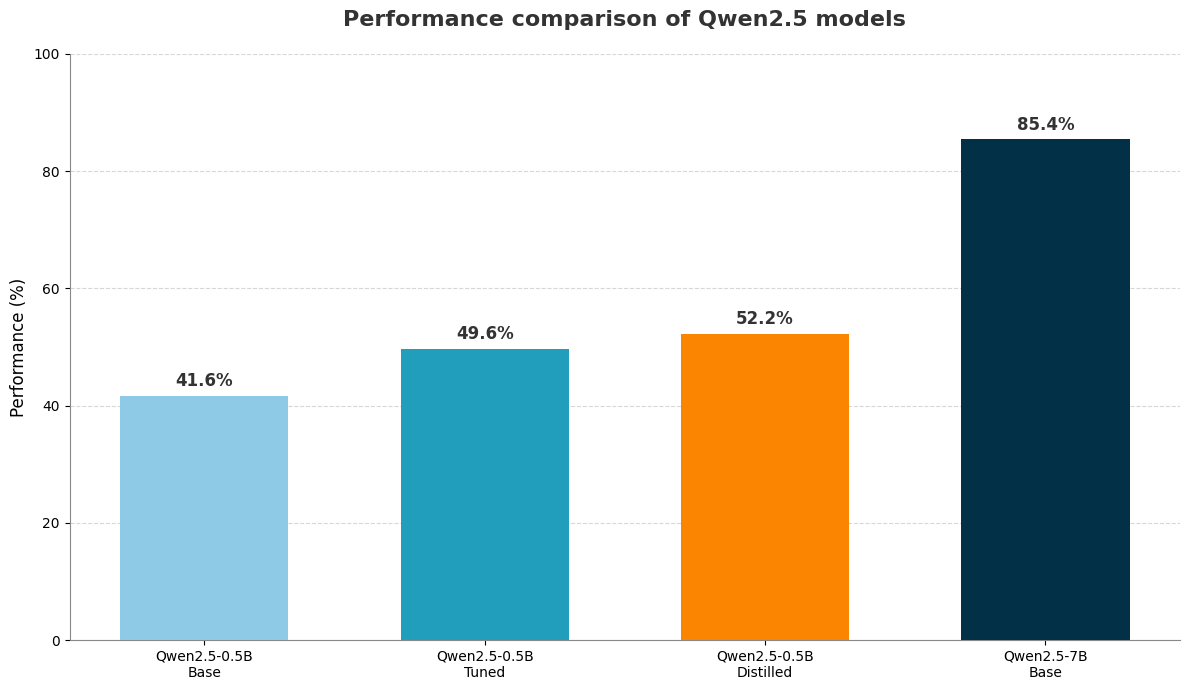

In [ ]:
# Visualization result
# Result from my project and Qwen paper
models = [
    "Qwen2.5-0.5B\nBase",
    "Qwen2.5-0.5B\nTuned",
    "Qwen2.5-0.5B\nDistilled",
    "Qwen2.5-7B\nBase"
]
scores = [41.6, 49.6, 52.2, 85.4]
colors = ['#8ecae6', '#219ebc', '#fb8500', '#023047']
plt.figure(figsize=(12, 7))
bars = plt.bar(models, scores, color=colors, width=0.6, zorder=3)
plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

plt.title('Performance comparison of Qwen2.5 models', fontsize=16, fontweight='bold', pad=20, color='#333333')
plt.ylabel('Performance (%)', fontsize=12)
plt.ylim(0, 100)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#888888')
plt.gca().spines['bottom'].set_color('#888888')

plt.tight_layout()